<a href="https://colab.research.google.com/github/mahapara2411/Sentiment-Analysis/blob/master/Pareto_NBD_Customer_Segmentation_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [214]:
!pip install lifetimes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [215]:
import re
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import altair as alt
import plotly.express as px
import xlrd
import pandas as pd
import warnings
import lifetimes
import dill as pickle
from sklearn.cluster import KMeans
from lifetimes import ParetoNBDFitter, GammaGammaFitter
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.plotting import plot_history_alive
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
from sklearn.metrics import mean_squared_error, r2_score
import math
from math import sqrt
warnings.filterwarnings("ignore")
import datetime
np.random.seed(42)

In [216]:
data = pd.read_excel("Retail_cleaned_dataset.xlsx")

In [217]:
data["TotalPrice"] = data["Quantity"]*data["Price"]
data['InvoiceDate'] = data.InvoiceDate.dt.date

In [218]:
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2019-12-01,6.95,13085,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2019-12-01,6.75,13085,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2019-12-01,6.75,13085,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2019-12-01,2.10,13085,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2019-12-01,1.25,13085,United Kingdom,30.0


In [219]:
rfm_summary = lifetimes.utils.summary_data_from_transaction_data(data, "CustomerID", "InvoiceDate", "TotalPrice")

In [220]:
rfm_summary.reset_index(inplace = True)

In [221]:
px.histogram(rfm_summary, x=rfm_summary['frequency'],title='Frequency of purchase',
                   labels={'frequency':'Frequency'}, 
                   opacity=0.8, marginal='violin',
                   color_discrete_sequence=['indianred'])

In [222]:
px.histogram(rfm_summary, x=rfm_summary['recency'],title='Recency of purchase',
                   labels={'recency':'Recency'}, nbins=50,
                   opacity=0.8, marginal='violin',
                   color_discrete_sequence=['indianred'])

In [223]:
px.histogram(rfm_summary, x=rfm_summary['T'],title='Time from first purchase',
                   labels={'T':'Weeks'}, 
                   opacity=0.8, marginal='violin',
                   color_discrete_sequence=['indianred'])

In [224]:
px.histogram(rfm_summary, x=rfm_summary['monetary_value'],title='Monetary Value of purchase',
                   labels={'monetary_value':'Weeks'}, 
                   opacity=0.8, marginal='violin',
                   color_discrete_sequence=['indianred'])

In [225]:
rfm_summary.describe(percentiles = [0.01,0.1,0.25,0.50,0.75,0.90,0.99])

,CustomerID,frequency,recency,T,monetary_value
count,5878.000000,5878.000000,5878.000000,5878.000000,5878.000000
mean,15315.313542,4.632358,273.647669,474.551718,312.996561
std,1715.572666,9.999783,259.242435,223.394778,2255.743170
min,12346.000000,0.000000,0.000000,0.000000,0.000000
1%,12405.770000,0.000000,0.000000,15.000000,0.000000
10%,12936.700000,0.000000,0.000000,89.000000,0.000000
25%,13833.250000,0.000000,0.000000,313.000000,0.000000
50%,15314.500000,2.000000,221.000000,530.000000,207.117500
75%,16797.750000,5.000000,512.000000,669.000000,368.045909
90%,17696.300000,11.000000,668.000000,731.000000,591.139417


In [226]:
rfm_summary.head()

,CustomerID,frequency,recency,T,monetary_value
0,12346,7.0,401.0,726.0,11066.637143
1,12347,7.0,402.0,404.0,615.714286
2,12348,4.0,363.0,438.0,449.310000
3,12349,3.0,571.0,589.0,1120.056667
4,12350,0.0,0.0,310.0,0.000000


**Pareto/NBD Model**

In [227]:
def get_model(data, penalizer_val, time):
    
    pareto_result = data.copy()

    pareto_model = ParetoNBDFitter(penalizer_coef = penalizer_val)
    pareto_model.fit(pareto_result["frequency"], pareto_result["recency"], pareto_result["T"])

    #calculating the predicted_purchases

    t = time

    pareto_result["predicted_purchases"] = pareto_model.conditional_expected_number_of_purchases_up_to_time(t, pareto_result["frequency"], pareto_result["recency"], pareto_result["T"])


    pareto_result["Actual_Purchases"] = pareto_result["frequency"]/pareto_result["recency"]*time

    #filling the null values
    pareto_result["Actual_Purchases"].fillna(0, inplace = True)


    #calculating the error
    pareto_result["Prediction_Error"] = pareto_result["Actual_Purchases"]-pareto_result["predicted_purchases"]

    #calcuating the purchase prediction error
    pareto_mse_purchase = mean_squared_error(pareto_result["Actual_Purchases"], pareto_result["predicted_purchases"])
    pareto_r2_purchase = r2_score(pareto_result["Actual_Purchases"], pareto_result["predicted_purchases"])
    pareto_rmse_purchase = sqrt(mean_squared_error(pareto_result["Actual_Purchases"], pareto_result["predicted_purchases"]))
    pareto_avg_error_purchase = pareto_result["Prediction_Error"].mean()
    
    #printing the purchase prediction error
    print("Predicted Purchase Mean Squared Error: %s" %(pareto_mse_purchase))
    print("Predicted Purchase R2 Score: %s" %(pareto_r2_purchase))
    print("Predicted Purchase Root Mean Squared Error: %s" %(pareto_rmse_purchase))
    print("Predicted Purchase Average Purchases Error: %s" %(pareto_avg_error_purchase))
    
    
    #plotting the prediction v/s actual purchase plot
    plt.figure(figsize=(6,4))
    plt.errorbar(pareto_result["Actual_Purchases"], pareto_result["predicted_purchases"], yerr=pareto_result["Prediction_Error"], fmt='o', color='darkseagreen',
                 ecolor='grey', elinewidth=1.5, capsize=0, alpha = 0.2);
    plt.title("Prediction v/s Actual")

Predicted Purchase Mean Squared Error: 2.2178054572100874
Predicted Purchase R2 Score: 0.060510353555273455
Predicted Purchase Root Mean Squared Error: 1.4892298201453285
Predicted Purchase Average Purchases Error: 0.23184043664196166


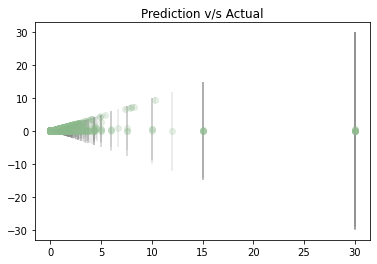

In [228]:
get_model(rfm_summary, 0.001, 30)

In [229]:
pareto_model = lifetimes.ParetoNBDFitter(penalizer_coef = 0.1)

In [230]:
pareto_model.fit(rfm_summary["frequency"],rfm_summary["recency"],
                rfm_summary["T"])

<lifetimes.ParetoNBDFitter: fitted with 5878 subjects, alpha: 72.03, beta: 385.66, r: 0.74, s: 0.18>

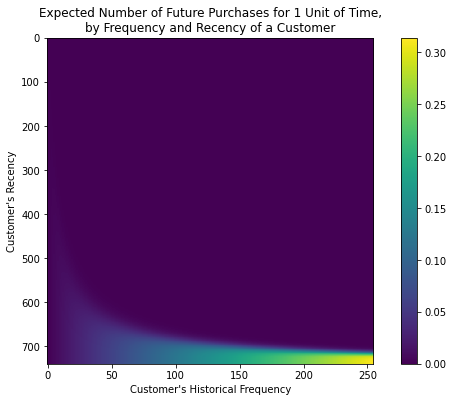

In [231]:
plt.figure(figsize=(10,6))
plot_frequency_recency_matrix(pareto_model)

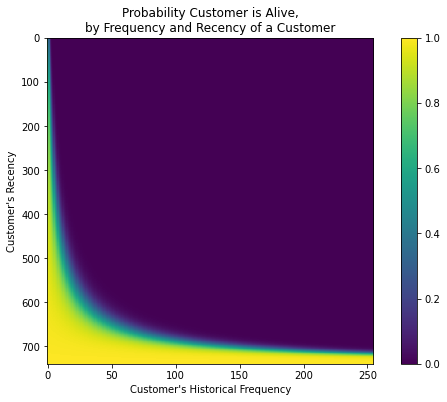

In [232]:
plt.figure(figsize=(10,6))
plot_probability_alive_matrix(pareto_model)

In [233]:
pareto_result = rfm_summary.copy()

In [234]:
pareto_result["p_not_alive"] = 1-pareto_model.conditional_probability_alive(pareto_result["frequency"], pareto_result["recency"], pareto_result["T"])
pareto_result["p_alive"] = pareto_model.conditional_probability_alive(pareto_result["frequency"], pareto_result["recency"], pareto_result["T"])

In [235]:
pareto_result.head()

,CustomerID,frequency,recency,T,monetary_value,p_not_alive,p_alive
0,12346,7.0,401.0,726.0,11066.637143,0.465187,0.534813
1,12347,7.0,402.0,404.0,615.714286,0.000467,0.999533
2,12348,4.0,363.0,438.0,449.310000,0.025307,0.974693
3,12349,3.0,571.0,589.0,1120.056667,0.003551,0.996449
4,12350,0.0,0.0,310.0,0.000000,0.167712,0.832288


In [236]:
t = 30
pareto_result["predicted_purchases"] = pareto_model.conditional_expected_number_of_purchases_up_to_time(t, pareto_result["frequency"], pareto_result["recency"], pareto_result["T"])

In [237]:
pareto_result

,CustomerID,frequency,recency,T,monetary_value,p_not_alive,p_alive,predicted_purchases
0,12346,7.0,401.0,726.0,11066.637143,0.465187,0.534813,0.155209
1,12347,7.0,402.0,404.0,615.714286,0.000467,0.999533,0.485818
2,12348,4.0,363.0,438.0,449.310000,0.025307,0.974693,0.270791
3,12349,3.0,571.0,589.0,1120.056667,0.003551,0.996449,0.168606
4,12350,0.0,0.0,310.0,0.000000,0.167712,0.832288,0.048093
...,...,...,...,...,...,...,...,...
5873,18283,18.0,656.0,659.0,142.666667,0.000541,0.999459,0.766602
5874,18284,0.0,0.0,431.0,0.000000,0.222904,0.777096,0.034122
5875,18285,0.0,0.0,661.0,0.000000,0.309941,0.690059,0.020808
5876,18286,1.0,248.0,724.0,833.480000,0.201957,0.798043,0.052165


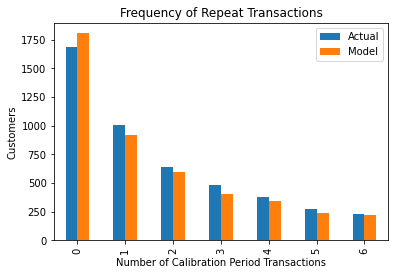

In [238]:
plot_period_transactions(pareto_model)

In [239]:
#dividing our dataset into training & holdout
pareto_summary_cal_holdout = calibration_and_holdout_data(data, "CustomerID", "InvoiceDate", 
                                                   calibration_period_end = '2021-06-08',
                                                  observation_period_end = '2021-12-09')

In [240]:
pareto_summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
CustomerID,,,,,
12346,7.0,401.0,542.0,0.0,184.0
12347,3.0,158.0,220.0,4.0,184.0
12348,3.0,190.0,254.0,1.0,184.0
12349,2.0,182.0,405.0,1.0,184.0
12350,0.0,0.0,126.0,0.0,184.0


In [241]:
pareto_model.fit(pareto_summary_cal_holdout["frequency_cal"],
               pareto_summary_cal_holdout["recency_cal"],
               pareto_summary_cal_holdout["T_cal"])

<lifetimes.ParetoNBDFitter: fitted with 4966 subjects, alpha: 74.34, beta: 1657.15, r: 0.74, s: 0.69>

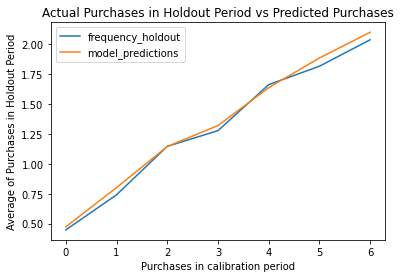

In [242]:
plot_calibration_purchases_vs_holdout_purchases(pareto_model, pareto_summary_cal_holdout)

In [243]:
pareto_summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
CustomerID,,,,,
12346,7.0,401.0,542.0,0.0,184.0
12347,3.0,158.0,220.0,4.0,184.0
12348,3.0,190.0,254.0,1.0,184.0
12349,2.0,182.0,405.0,1.0,184.0
12350,0.0,0.0,126.0,0.0,184.0


In [252]:
pareto_result["actual30"] = pareto_result["frequency"]/pareto_result["recency"]*30

In [253]:
pareto_result["actual30"].fillna(0, inplace = True)

In [254]:
pareto_result["error"] = pareto_result["actual30"]-pareto_result["predicted_purchases"]

In [255]:
pareto_result.head()

,CustomerID,frequency,recency,T,monetary_value,p_not_alive,p_alive,predicted_purchases,actual30,error
0,12346,7.0,401.0,726.0,11066.637143,0.465187,0.534813,0.155209,0.523691,0.368482
1,12347,7.0,402.0,404.0,615.714286,0.000467,0.999533,0.485818,0.522388,0.036570
2,12348,4.0,363.0,438.0,449.310000,0.025307,0.974693,0.270791,0.330579,0.059788
3,12349,3.0,571.0,589.0,1120.056667,0.003551,0.996449,0.168606,0.157618,-0.010988
4,12350,0.0,0.0,310.0,0.000000,0.167712,0.832288,0.048093,0.000000,-0.048093


In [256]:
def get_metrics(true, predicted, error):
    
    print("Mean Squared Error: %s"%(mean_squared_error(true, predicted)))
    print("Root Mean Squared Error: %s"%(sqrt(mean_squared_error(true, predicted))))
    print("R2 Score: %s"%(r2_score(true, predicted)))
    
    sns.scatterplot(true, predicted, size = error, color = "darkolivegreen")
    plt.title("Actual Purchase v/s Predicted Purchase")
    plt.show()

Mean Squared Error: 2.2178118875611887
Root Mean Squared Error: 1.489231979095664
R2 Score: 0.060507629579523825


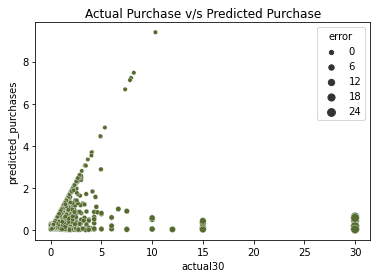

In [257]:
get_metrics(pareto_result["actual30"], pareto_result["predicted_purchases"], pareto_result["error"])

In [258]:
#Get the history alive plot to check whether the customer is alive or not

def get_history_alive(t_, data_, id_):
    
    individual_alive = data[data["CustomerID"] == id_]
    plot_history_alive(pareto_model, t = t_, transactions = individual_alive, datetime_col = "InvoiceDate",
                  freq = "D")

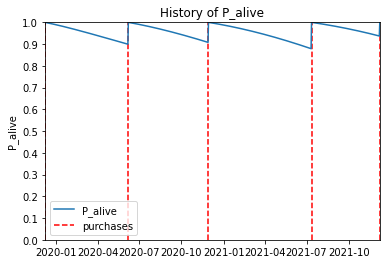

In [259]:
get_history_alive(30, data, 12358.0)

**GAMMA-GAMMA MODEL**

In [260]:
idx = pareto_result[(pareto_result["frequency"] <= 0.0)]

In [261]:
idx = idx.index

In [262]:
ggf_filter = pareto_result.drop(idx, axis = 0)

In [263]:
m_idx = ggf_filter[(ggf_filter["monetary_value"] <= 0.0)].index

In [264]:
ggf_filter = ggf_filter.drop(m_idx, axis = 0)

In [265]:
ggf_filter.reset_index().drop("index", axis = 1, inplace = True)

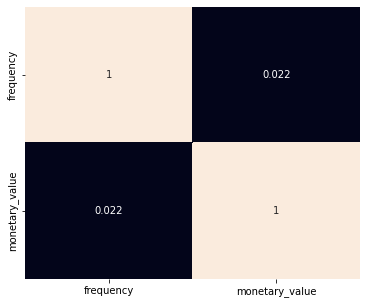

In [266]:
plt.figure(figsize=(6,5))
sns.heatmap(ggf_filter[["frequency", "monetary_value"]].corr(), annot = True, cbar = False)

In [267]:
ggf_model =  lifetimes.GammaGammaFitter(penalizer_coef=0.1)

In [268]:
ggf_model.fit(ggf_filter["frequency"], ggf_filter["monetary_value"])

<lifetimes.GammaGammaFitter: fitted with 4189 subjects, p: 1.02, q: 0.18, v: 0.93>

In [269]:
ggf_model.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,1.019926,0.024531,0.971846,1.068006
q,0.179152,0.002996,0.173280,0.185023
v,0.933467,0.025489,0.883508,0.983426


In [270]:
ggf_filter["expected_avg_sales_"] = ggf_model.conditional_expected_average_profit(ggf_filter["frequency"],
                                                                                     ggf_filter["monetary_value"])

In [271]:
ggf_filter.head()

,CustomerID,frequency,recency,T,monetary_value,p_not_alive,p_alive,predicted_purchases,actual30,error,expected_avg_sales_
0,12346,7.0,401.0,726.0,11066.637143,0.465187,0.534813,0.155209,0.523691,0.368482,12504.444869
1,12347,7.0,402.0,404.0,615.714286,0.000467,0.999533,0.485818,0.522388,0.036570,695.851861
2,12348,4.0,363.0,438.0,449.310000,0.025307,0.974693,0.270791,0.330579,0.059788,562.775388
3,12349,3.0,571.0,589.0,1120.056667,0.003551,0.996449,0.168606,0.157618,-0.010988,1531.122915
6,12352,8.0,356.0,392.0,338.261250,0.012357,0.987643,0.556060,0.674157,0.118098,376.226899


In [272]:
print("Mean Squared Error: %s" %(mean_squared_error(ggf_filter["monetary_value"], ggf_filter["expected_avg_sales_"])))
print("Root Mean Squared Error: %s" %(sqrt(mean_squared_error(ggf_filter["monetary_value"], ggf_filter["expected_avg_sales_"]))))
print("R2 Score: %s" %(r2_score(ggf_filter["monetary_value"], ggf_filter["expected_avg_sales_"])))

Mean Squared Error: 118447363.6217067
Root Mean Squared Error: 10883.352591077195
R2 Score: -15.721908585813079


In [273]:
ggf_filter["predicted_clv_1month"] = ggf_model.customer_lifetime_value(pareto_model,
                                                       ggf_filter["frequency"],
                                                       ggf_filter["recency"],
                                                       ggf_filter["T"],
                                                       ggf_filter["monetary_value"],
                                                       time = 30,
                                                       freq = 'W',
                                                       discount_rate = 0.01)

In [274]:
#Top 5 customers with high CLV
ggf_filter[["CustomerID", "predicted_clv_1month"]].sort_values(by = "predicted_clv_1month", ascending = False).head(5)

,CustomerID,predicted_clv_1month
4061,16446,591214.759695
5692,18102,80273.403294
2277,14646,72145.163441
189,12536,59606.054308
5050,17450,46288.728428


In [275]:
# 12 Month CLTV Forecast:

ggf_filter["predicted_clv_12months"] = ggf_model.customer_lifetime_value(pareto_model,
                                   ggf_filter['frequency'],
                                   ggf_filter['recency'],
                                   ggf_filter['T'],
                                   ggf_filter['monetary_value'],
                                   time=365,  # 1 aylık
                                   freq="W",  # T'nin frekans bilgisi
                                   discount_rate=0.01)

In [276]:
#Top 5 customers with high CLV
ggf_filter[["CustomerID", "predicted_clv_12months"]].sort_values(by = "predicted_clv_12months", ascending = False).head(5)

,CustomerID,predicted_clv_12months
4061,16446,2.023645e+06
5692,18102,2.798340e+05
2277,14646,2.514919e+05
189,12536,2.026800e+05
5050,17450,1.598621e+05


In [277]:
# Assuming 5% of Profit Margin
ggf_filter["profit_margin"] = ggf_filter["predicted_clv_1month"]*0.05

In [278]:
ggf_filter.reset_index().drop("index", axis = 1, inplace = True)

In [279]:
#exporting the result to csv
ggf_filter.to_csv("customer_lifetime_value_prediction.csv")

**CUSTOMER SEGMENTATION USING PREDICTED CLV**

In [280]:
ggf_filter.head()

,CustomerID,frequency,recency,T,monetary_value,p_not_alive,p_alive,predicted_purchases,actual30,error,expected_avg_sales_,predicted_clv_1month,predicted_clv_12months,profit_margin
0,12346,7.0,401.0,726.0,11066.637143,0.465187,0.534813,0.155209,0.523691,0.368482,12504.444869,5674.042864,19772.615824,283.702143
1,12347,7.0,402.0,404.0,615.714286,0.000467,0.999533,0.485818,0.522388,0.036570,695.851861,1237.318103,4268.065174,61.865905
2,12348,4.0,363.0,438.0,449.310000,0.025307,0.974693,0.270791,0.330579,0.059788,562.775388,552.221293,1907.143773,27.611065
3,12349,3.0,571.0,589.0,1120.056667,0.003551,0.996449,0.168606,0.157618,-0.010988,1531.122915,945.940927,3283.108247,47.297046
6,12352,8.0,356.0,392.0,338.261250,0.012357,0.987643,0.556060,0.674157,0.118098,376.226899,761.748037,2626.478375,38.087402


In [281]:
col = ["predicted_purchases", "expected_avg_sales_", "predicted_clv_1month", "profit_margin"]

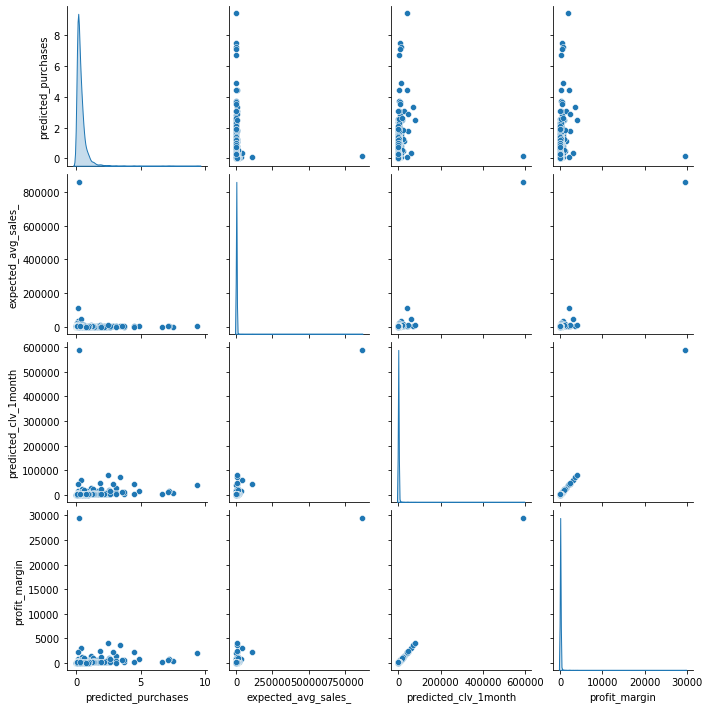

In [282]:
sns.pairplot(ggf_filter[col], diag_kind = "kde")

In [283]:
new_df = ggf_filter[col]
print(new_df)

      predicted_purchases  expected_avg_sales_  predicted_clv_1month  \
0                0.155209         12504.444869           5674.042864   
1                0.485818           695.851861           1237.318103   
2                0.270791           562.775388            552.221293   
3                0.168606          1531.122915            945.940927   
6                0.556060           376.226899            761.748037   
...                   ...                  ...                   ...   
5871             0.076241           418.843596            114.438379   
5872             0.261352           403.576306            384.007340   
5873             0.766602           149.398389            420.194603   
5876             0.052165          4274.910277            747.399841   
5877             0.264345           741.876901            715.377691   

      profit_margin  
0        283.702143  
1         61.865905  
2         27.611065  
3         47.297046  
6         38.087402  
...

In [284]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled = scaler.fit_transform(new_df)
scaled

array([[-0.41880395,  0.84962533,  0.48906562,  0.48906562],
       [ 0.31418264, -0.02520103,  0.02407033,  0.02407033],
       [-0.16255025, -0.03505985, -0.04773191, -0.04773191],
       ...,
       [ 0.93670243, -0.06568442, -0.06156909, -0.06156909],
       [-0.64726016,  0.2399495 , -0.02727603, -0.02727603],
       [-0.17684106, -0.02179131, -0.03063214, -0.03063214]])

In [285]:
inertia = []

for i in range(1, 11):
    kmeans  = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(scaled)
    inertia.append(kmeans.inertia_)

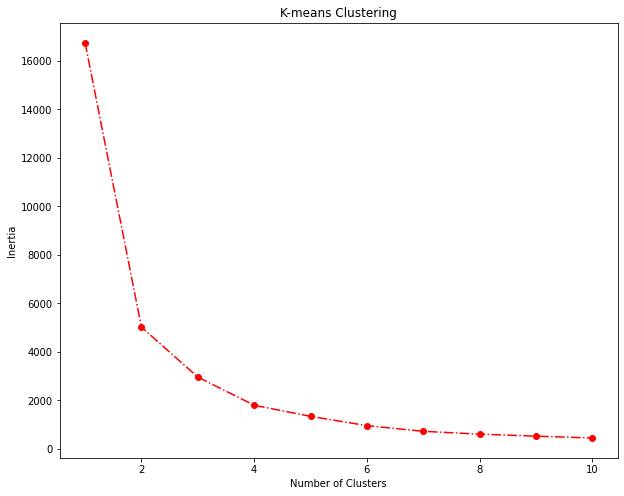

In [286]:
plt.figure(figsize = (10,8))
plt.plot(range(1, 11), inertia, marker = 'o', linestyle = '-.',color='red')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('K-means Clustering')
plt.show()

In [287]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)

In [288]:
kmeans.fit(scaled)

KMeans(n_clusters=3, random_state=42)

In [289]:
df_segm_kmeans= new_df.copy()
df_segm_kmeans['Segment K-means'] = kmeans.labels_

In [290]:
df_segm_analysis = df_segm_kmeans.groupby(['Segment K-means']).mean()
df_segm_analysis

,predicted_purchases,expected_avg_sales_,predicted_clv_1month,profit_margin
Segment K-means,,,,
0,0.283328,820.983067,653.796286,32.689814
1,0.187433,863116.959561,591214.759695,29560.737985
2,1.905651,1066.185421,6333.684658,316.684233


In [291]:
df_segm_analysis.rename({0:'Low',
                         1:'High',
                         2:'Medium'
                        })

,predicted_purchases,expected_avg_sales_,predicted_clv_1month,profit_margin
Segment K-means,,,,
Low,0.283328,820.983067,653.796286,32.689814
High,0.187433,863116.959561,591214.759695,29560.737985
Medium,1.905651,1066.185421,6333.684658,316.684233


In [292]:
# Add the segment labels to our table
df_segm_kmeans['Labels'] = df_segm_kmeans['Segment K-means'].map({0:'Low',
                                                                  1:'High',
                                                                  2:'Medium',
                                                                  })

In [293]:
df_segm_kmeans.head()

,predicted_purchases,expected_avg_sales_,predicted_clv_1month,profit_margin,Segment K-means,Labels
0,0.155209,12504.444869,5674.042864,283.702143,0,Low
1,0.485818,695.851861,1237.318103,61.865905,0,Low
2,0.270791,562.775388,552.221293,27.611065,0,Low
3,0.168606,1531.122915,945.940927,47.297046,0,Low
6,0.556060,376.226899,761.748037,38.087402,0,Low


In [294]:
ggf_filter_Kmeans = pd.concat([ggf_filter,df_segm_kmeans['Segment K-means'],df_segm_kmeans['Labels']], axis = 1)

In [295]:
ggf_filter_Kmeans.head()

,CustomerID,frequency,recency,T,monetary_value,p_not_alive,p_alive,predicted_purchases,actual30,error,expected_avg_sales_,predicted_clv_1month,predicted_clv_12months,profit_margin,Segment K-means,Labels
0,12346,7.0,401.0,726.0,11066.637143,0.465187,0.534813,0.155209,0.523691,0.368482,12504.444869,5674.042864,19772.615824,283.702143,0,Low
1,12347,7.0,402.0,404.0,615.714286,0.000467,0.999533,0.485818,0.522388,0.036570,695.851861,1237.318103,4268.065174,61.865905,0,Low
2,12348,4.0,363.0,438.0,449.310000,0.025307,0.974693,0.270791,0.330579,0.059788,562.775388,552.221293,1907.143773,27.611065,0,Low
3,12349,3.0,571.0,589.0,1120.056667,0.003551,0.996449,0.168606,0.157618,-0.010988,1531.122915,945.940927,3283.108247,47.297046,0,Low
6,12352,8.0,356.0,392.0,338.261250,0.012357,0.987643,0.556060,0.674157,0.118098,376.226899,761.748037,2626.478375,38.087402,0,Low


In [296]:
ggf_filter_Kmeans.groupby('Labels').CustomerID.count()/ggf_filter_Kmeans.CustomerID.count()*100

Labels
High       0.023872
Low       96.228217
Medium     3.747911
Name: CustomerID, dtype: float64

In [297]:
ggf_filter_Kmeans.to_csv("Segmentation_result.csv")

**Machine Learning: Xgboost and Lightgbm Algorithm**

In [298]:
data.InvoiceDate

0         2019-12-01
1         2019-12-01
2         2019-12-01
3         2019-12-01
4         2019-12-01
             ...    
779423    2021-12-09
779424    2021-12-09
779425    2021-12-09
779426    2021-12-09
779427    2021-12-09
Name: InvoiceDate, Length: 779428, dtype: object

In [299]:
import datetime

dfnew_train = data[data.InvoiceDate <= datetime.date(2021,6, 8)]
dfnew_test = data[data.InvoiceDate > datetime.date(2021,6, 8)]

maxdate = dfnew_train.InvoiceDate.max()
mindate = dfnew_train.InvoiceDate.min()

dfnew_train['duration'] =  (maxdate - dfnew_train.InvoiceDate)/np.timedelta64(1, 'D')
# get time duration between the last transaction to now
dfsum1 = dfnew_train.groupby(['CustomerID'])['duration'].min().reset_index()
dfsum1.rename(columns = {'duration':'latetime'}, inplace = True)

# get time duration between the first transaction to now
dfsum2 = dfnew_train.groupby(['CustomerID'])['duration'].max().reset_index()
dfsum2.rename(columns = {'duration':'earlytime'}, inplace = True)

# get transaction frequency (whole history)
dfsum3 = dfnew_train.groupby(['CustomerID'])['InvoiceDate'].nunique().reset_index()
dfsum3.rename(columns={'InvoiceDate': 'freq'}, inplace=True)
# get transaction frequency (recent 3 months history)
dfsum4 = dfnew_train[dfnew_train.duration<91].groupby(['CustomerID'])['InvoiceDate'].nunique().reset_index()
dfsum4.rename(columns={'InvoiceDate': 'freq_3m'}, inplace=True)

dfsum = pd.merge(dfsum1, dfsum2, on=['CustomerID'], how='outer')
dfsum = pd.merge(dfsum, dfsum3, on=['CustomerID'], how='outer')
dfsum = pd.merge(dfsum, dfsum4, on=['CustomerID'], how='outer')

# get target: number of transactions in test set
dfsum_target = dfnew_test.groupby(['CustomerID'])['InvoiceDate'].nunique().reset_index()
dfsum_target.rename(columns={'InvoiceDate': 'target'}, inplace=True)
dfsum = pd.merge(dfsum, dfsum_target, on=['CustomerID'], how='left')
dfsum  = dfsum.fillna(0).sort_values(['target'], ascending = False)

In [300]:
dfsum.head(10)

,CustomerID,latetime,earlytime,freq,freq_3m,target
2122,14911,0.0,555.0,172,28.0,83.0
309,12748,0.0,552.0,133,21.0,69.0
4592,17841,0.0,554.0,127,24.0,66.0
2466,15311,1.0,555.0,150,15.0,46.0
1858,14606,1.0,553.0,139,21.0,42.0
490,12971,6.0,541.0,62,16.0,37.0
594,13089,1.0,554.0,102,18.0,30.0
1467,14156,2.0,555.0,93,8.0,28.0
1790,14527,0.0,554.0,93,12.0,28.0
1894,14646,7.0,554.0,66,11.0,25.0


**XG Boost Model**



In [301]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

xgb_model = xgb.XGBRegressor(n_estimators=2200, objective='reg:linear', max_depth = 3)
 
predictors = ['latetime','earlytime', 'freq','freq_3m']
X = dfsum[predictors]
y = dfsum.target

x_trains, x_valids, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=12)

xgb_model.fit(x_trains, y_train)

[07:20:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(n_estimators=2200)

In [302]:
y_pred = xgb_model.predict(x_valids)
rmse = mean_squared_error(y_valid, y_pred)**(1/2)
print('RMSE on test set: ', rmse)

RMSE on test set:  2.1937122266158005


In [303]:
from sklearn.preprocessing import StandardScaler

In [304]:
xgb_model2 = xgb.XGBRegressor(n_estimators=2200, objective='reg:linear', max_depth = 3)
xgb_model2.fit(X, y)
y_pred2 = xgb_model2.predict(X)
print('RMSE: ', mean_squared_error(y, y_pred2)**(1/2))
#print('SMAPE', smape(y, y_pred2))
print('R2: ', r2_score(y, y_pred2))

[07:20:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE:  1.0270147031367824
R2:  0.9031204709526421


**Feature Importance**



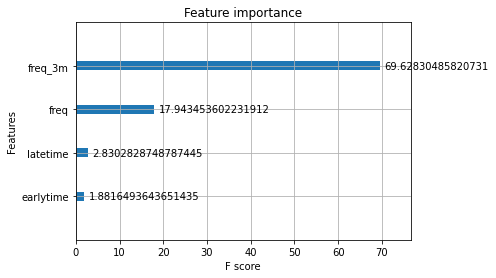

In [305]:
xgb.plot_importance(xgb_model, importance_type='gain')

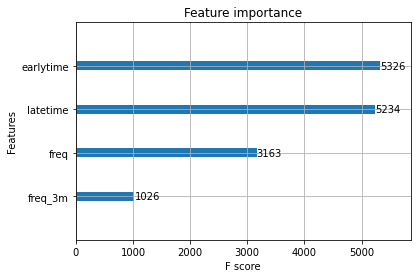

In [306]:
xgb.plot_importance(xgb_model, importance_type='weight')

In [307]:
import lightgbm as lgb

lgbparams = {
    'n_estimators': 2200, 
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'mse',    
    'max_depth': 3, 
    'learning_rate': 0.02
}

lgb_model = lgb.LGBMRegressor(**lgbparams)
 
predictors = ['latetime','earlytime', 'freq','freq_3m']
X = dfsum[predictors]
y = dfsum.target

x_trains, x_valids, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=12)

lgb_model.fit(x_trains, y_train)


LGBMRegressor(learning_rate=0.02, max_depth=3, metric='mse', n_estimators=2200,
              objective='regression')

In [308]:
y_pred = lgb_model.predict(x_valids)
rmse = mean_squared_error(y_valid, y_pred)**(1/2)
print('RMSE on test set: ', rmse)

RMSE on test set:  2.4370120422733343


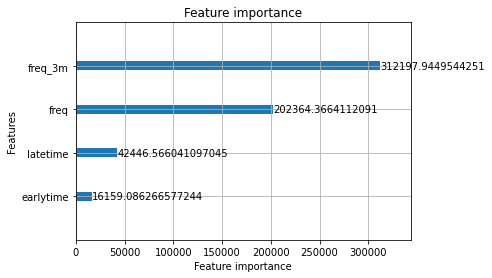

In [309]:
lgb.plot_importance(lgb_model, importance_type='gain')

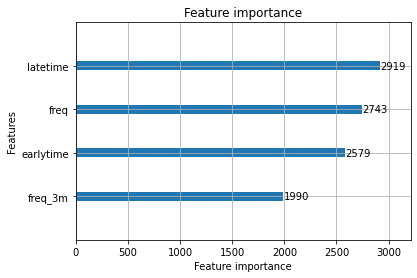

In [310]:
lgb.plot_importance(lgb_model) # defualt: weight

In [311]:
lgb_model2 = lgb.LGBMRegressor(**lgbparams)
lgb_model2.fit(X, y)
y_pred3 = lgb_model2.predict(X)
print('RMSE: ', mean_squared_error(y, y_pred3)**(1/2))
#print('SMAPE', smape(y, y_pred3))
print('R2: ', r2_score(y, y_pred3))

RMSE:  1.6509330413667973
R2:  0.7496557530253511
